## Table des matières

- [Création de l'échantillon 'data'](#chapitre_1)
- [Dendrogramme](#chapitre_2)
- [Coupage du dendrogramme en 5 clusters](#chapitre_3)
- [Nombre de pays par clusters](#chapitre_4)
- [Analyse en composantes principales](#chapitre_5)
- [Caractérisation des clusters selon les variables](#chapitre_6)
- [Calcul des composantes principales](#chapitre_7)
- [Liste des pays à cibler](#chapitre_8)
- [Visualisation dans le premier plan factoriel obtenu par ACP](#chapitre_9)
- [Tests d'adéquation](#chapitre_10)
- [Test de comparaison](#chapitre_11)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings('ignore')

population = pd.read_csv("population_2016_2017.csv")
dispAlim = pd.read_csv("disp_alim_totale_2017.csv")
dispAlimAnimaux = pd.read_csv("disp_alim_animaux_2017.csv")
PIBparHab = pd.read_csv("PIB_par_Hab.csv", sep=";", decimal = ",")

L'étude se base sur les chiffres de la FAO de l'année 2017.

Le PIB par habitant provient de cette source : https://donnees.banquemondiale.org/

Elle est complétée par les sources suivantes pour ces pays :
   - République démocratique populaire de Corée : https://www.populationdata.net/pays/coree-du-nord/
   - Djibouti : https://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?langue=fr&codePays=DJI&codeStat=NY.GDP.PCAP.PP.CD&codeStat2=x
   - Érythrée : https://fr.countryeconomy.com/gouvernement/pib/erythree
   - Nouvelle-Calédonie : https://www.lefigaro.fr/economie/le-scan-eco/2017/12/02/29001-20171202ARTFIG00004-du-nickel-au-tourisme-8-choses-a-savoir-sur-l-economie-de-la-nouvelle-caledonie.php
   - Polynésie française : http://www.polynesie-francaise.pref.gouv.fr/content/download/28076/146842/file/EC_Regards-eco-PF_oct2017.pdf (PIB 2016)
   - Venezuela : https://fr.wikipedia.org/wiki/%C3%89conomie_du_Venezuela

<a id="chapitre_1"></a>
## <span style="color: #030aa4">Création de l'échantillon 'data'</span>

In [2]:
# Création de dataPop pour la population de chaque pays en 2016 et 2017 :

dataPop = population.loc[ : ,('Code zone','Zone','Année','Valeur')]\
                    .pivot_table(index = ['Code zone','Zone'], columns = 'Année', values='Valeur', aggfunc = sum)\
                    .reset_index()

# Vu dans projet 3 :
# La Chine apparaît deux fois :
# - Chine, continentale (Code zone = 41), donnée officielle
# - Chine (Code zone = 351), agrégat incluant des données non officielles

# Suppression de l'élément "Chine" avec le code zone : 

dataPop = dataPop[dataPop["Code zone"]!=351]

# Création colonne "Différence de population entre 2016 et 2017 en %" :

dataPop['diff_pop'] = ((dataPop[2017]-dataPop[2016])/dataPop[2016])*100

# Création de dataAlim pour la disponibilité alimentaire totale :

dataAlim = dispAlim.pivot_table(index =['Zone','Code zone'],
                            columns='Élément', values='Valeur', aggfunc = sum)\
                   .loc[ : ,('Disponibilité alimentaire (Kcal/personne/jour)',
                             'Disponibilité de protéines en quantité (g/personne/jour)')]\
                   .reset_index()\
                   .rename(columns={'Disponibilité alimentaire (Kcal/personne/jour)':'disp_alim',
                                    'Disponibilité de protéines en quantité (g/personne/jour)':'disp_prot'})
dataAlim['disp_alim'] *= 365
dataAlim['disp_prot'] *= 365

# Suppression des valeurs incohérentes :

dataAlim = dataAlim.drop(dataAlim[dataAlim['disp_alim']<0].index)\
                   .drop(dataAlim[dataAlim['disp_prot']<0].index)\
                   .drop_duplicates()

# Création de dataAnim pour la disponibilité alimentaire animale :

dataAnim = dispAlimAnimaux.pivot_table(index =['Zone','Code zone'],
                            columns='Élément', values='Valeur', aggfunc = sum)\
                          .loc[ : ,('Disponibilité de protéines en quantité (g/personne/jour)')]\
                          .reset_index()\
                          .rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)':"Disponibilité d'origine animale de protéines en quantité (g/personne)"})
dataAnim["Disponibilité d'origine animale de protéines en quantité (g/personne)"] *= 365

# Suppression des valeurs incohérentes :

dataAnim = dataAnim.drop(dataAnim[dataAnim["Disponibilité d'origine animale de protéines en quantité (g/personne)"]<0].index)\
                   .drop_duplicates()

# Jointure de dataPop, dataAlim, dataAnim et PIBparHab : 

PIBparHab = PIBparHab.reset_index()\
                     .rename(columns={'PIB par hab.  En US Dollar 2017':"pib_hab"})

data = pd.merge(dataPop, dataAlim)
data = pd.merge(data, dataAnim)
data = pd.merge(data, PIBparHab)

data["prop_prot"] = (data["Disponibilité d'origine animale de protéines en quantité (g/personne)"]/data['disp_prot'])*100

data = data.drop(columns=['Code zone',2016,2017,"Disponibilité d'origine animale de protéines en quantité (g/personne)","index"])\
           .set_index('Zone')


data.tail(3)

,diff_pop,disp_alim,disp_prot,pib_hab,prop_prot
Zone,,,,,
Serbie,-0.274792,1023825.0,30112.50,6560.323194,48.509091
Monténégro,0.047827,1270565.0,41358.15,7845.368126,60.603654
Soudan,2.424146,888045.0,24776.20,1900.092771,31.128462


Description des variables :
- **diff_pop** : différence de population entre 2016 et 2017 en %
- **disp_alim** : disponibilité alimentaire totale (Kcal/personne)
- **disp_prot** : disponibilité totale de protéines en quantité (g/personne)
- **pib_hab** : PIB par habitant en Dollar US
- **prop_prot** : proportion de protéines d'origine animale par rapport à quantité totale de protéines dans disponibilité alimentaire en %

Les pays à cibler doivent avoir :
- une démographie en croissance
- une disponibilité alimentaire totale faible
- une disponibilité totale de protéines faible
- Un PIB par habitant élevé
- une proportion de protéines faible

<a id="chapitre_2"></a>
## <span style="color: #030aa4">Dendrogramme</span>

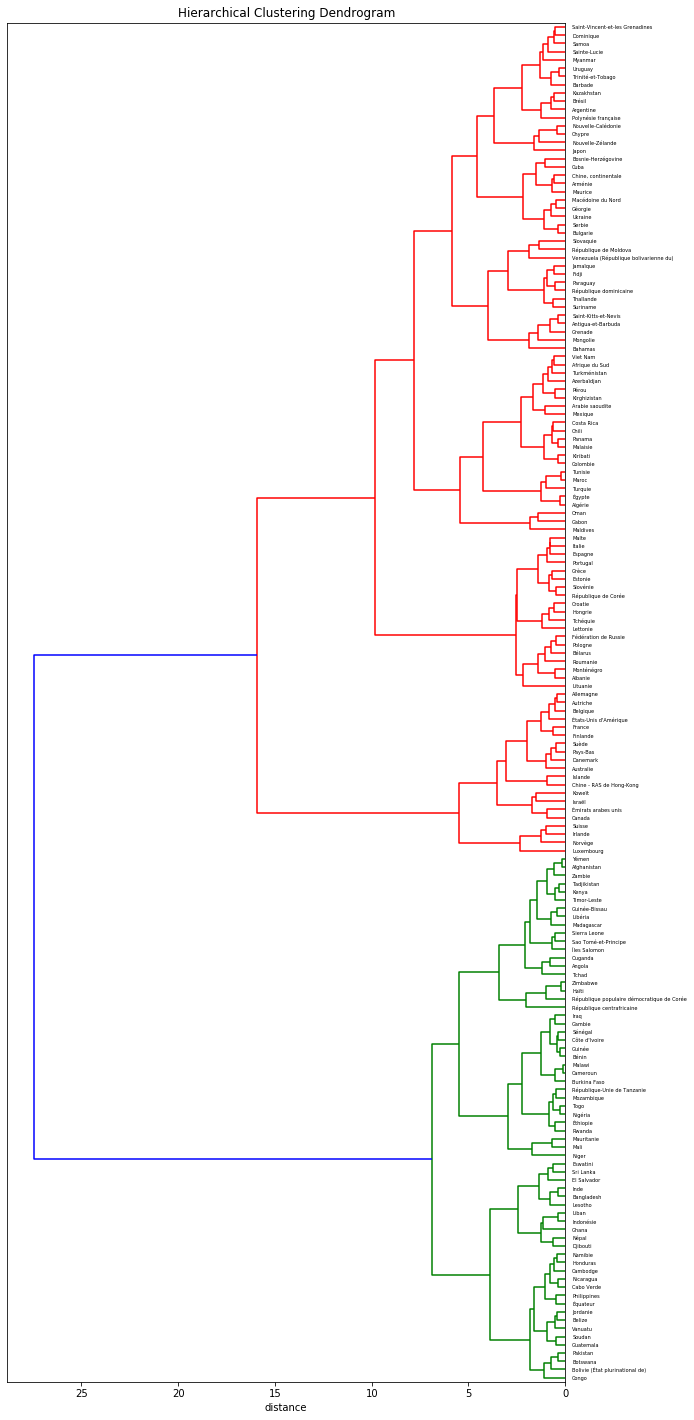

In [3]:
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
from scipy.cluster.hierarchy import linkage, fcluster


# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

<a id="chapitre_3"></a>
## <span style="color: #030aa4">Coupage du dendrogramme en 5 clusters</span>

In [4]:
clusters = fcluster(Z, 5, criterion='maxclust')

dataClusters = pd.DataFrame({"cluster": clusters, "Zone": names})

dataClusters.head(3)

,cluster,Zone
0,5,Arménie
1,1,Afghanistan
2,3,Albanie


<a id="chapitre_4"></a>
## <span style="color: #030aa4">Nombre de pays par clusters</span>

In [35]:
dataClusters["Nombre d'états"]=1

dataClusters.groupby('cluster')["Nombre d'états"].sum()

cluster
1    64
2    20
3    19
4    22
5    40
Name: Nombre d'états, dtype: int64

<a id="chapitre_5"></a>
## <span style="color: #030aa4">Analyse des clusters</span>

In [49]:
cluster = dataClusters.cluster.unique()

for i in cluster :
    print("Pays du cluster ",i , ":")
    print(" ")
    print(dataClusters[dataClusters.cluster==i].Zone.unique())
    print(" ")

Pays du cluster  5 :
 
['Arménie' 'Antigua-et-Barbuda' 'Argentine' 'Bahamas' 'Barbade' 'Brésil'
 'Bulgarie' 'Myanmar' 'Chine, continentale' 'Cuba' 'Chypre' 'Dominique'
 'République dominicaine' 'Fidji' 'Polynésie française' 'Géorgie'
 'Bosnie-Herzégovine' 'Grenade' 'Kazakhstan' 'Jamaïque' 'Japon' 'Maurice'
 'Mongolie' 'République de Moldova' 'Nouvelle-Calédonie'
 'Macédoine du Nord' 'Nouvelle-Zélande' 'Paraguay' 'Saint-Kitts-et-Nevis'
 'Sainte-Lucie' 'Saint-Vincent-et-les Grenadines' 'Slovaquie' 'Suriname'
 'Thaïlande' 'Trinité-et-Tobago' 'Ukraine' 'Uruguay'
 'Venezuela (République bolivarienne du)' 'Samoa' 'Serbie']
 
Pays du cluster  1 :
 
['Afghanistan' 'Angola' 'Bangladesh' 'Bolivie (État plurinational de)'
 'Botswana' 'Belize' 'Îles Salomon' 'Cameroun' 'Cabo Verde'
 'République centrafricaine' 'Sri Lanka' 'Tchad' 'Congo' 'Bénin'
 'Équateur' 'El Salvador' 'Djibouti' 'Gambie' 'Ghana' 'Guatemala' 'Guinée'
 'Haïti' 'Honduras' 'Inde' 'Indonésie' 'Iraq' "Côte d'Ivoire" 'Jordanie'
 'Keny

- Les **clusters 2 et 3** regroupent les pays où les disponibilités en nourriture sont élevées et ne semblent pas être nos clusters cibles.
- Le **cluster 1** regroupe les pays les plus pauvres.
- Les **clusters 4 et 5** regroupent des pays aux critères variés : économie instable, disparités, faible proportion de protéines d'origine animale...

<a id="chapitre_5"></a>
## <span style="color: #030aa4">Analyse en composantes principales</span>

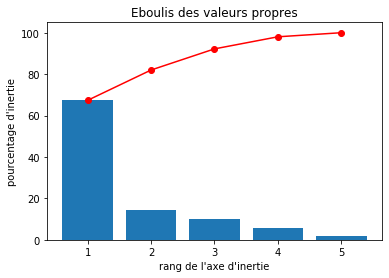

In [6]:
# choix du nombre de composantes à calculer
n_comp = 5

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

Selon la méthode du coude, la courbe baisse au niveau du deuxième rang. Les deux premiers rangs rassemblent plus de 80% de l'inertie totale. **On ne retient donc que les deux premiers axes d'inertie**.

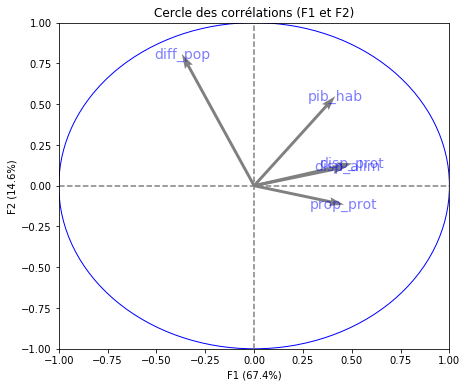

In [7]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

    
# choix du nombre de composantes à calculer
n_comp = 5

# sélection des colonnes à prendre en compte dans l'ACP
data_pca = data[['diff_pop',
                 'disp_alim',
                 'disp_prot',
                 'pib_hab',
                 'prop_prot']]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = data.index
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

**Description des variables synthétiques :**
    - F1 est :
        - faiblement anticorrélé avec la différence de population entre 2016 et 2017
        - corrélé avec la disponibilité alimentaire totale
        - corrélé avec la disponibilité totale de protéines en quantité
        - corrélé avec la proportion de protéine d'origine animale
        - corrélé avec le PIB par habitant
    - F2 est :
        - fortement corrélé avec la différence de population entre 2016 et 2017
        - faiblement corrélé avec la disponibilité alimentaire totale
        - faiblement corrélé avec la disponibilité totale de protéines en quantité
        - faiblement anticorrélé avec la proportion de protéine d'origine animale
        - corrélé avec le PIB par habitant

**Nous pouvons donc identifier F1 et F2 de la façon suivante :**
- **F1 : accès à la nourriture**
- **F2 : démographie/ économie**
        
**Nous cherchons donc le cluster avec des valeurs de :**
- **F1 négatives**
- **F2 positives.**

<a id="chapitre_6"></a>
## <span style="color: #030aa4">Caractérisation des clusters selon les variables</span>

Pour caractériser les clusters selon les variables , nous allons afficher les positions de leur centre de classe sur le premier plan factoriel.

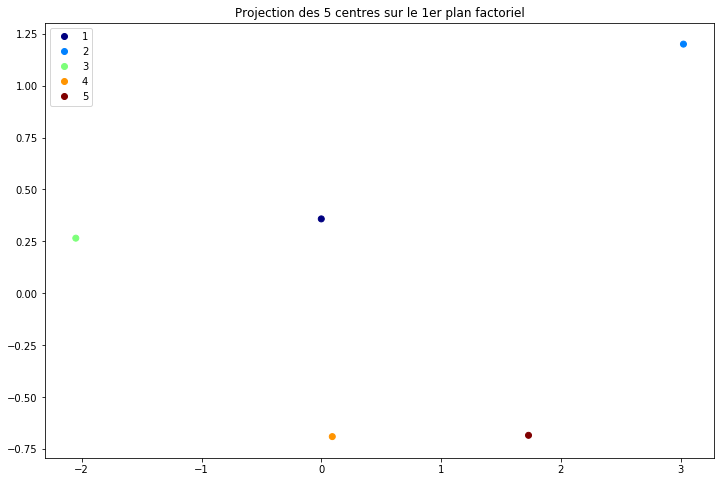

In [73]:
from sklearn.cluster import KMeans

# Nombre de clusters souhaités
n_clust = 5

# préparation des données pour le clustering
X = data.values

# Réduction
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=2).fit(X_scaled)
X_projected = pca.transform(X)

# Affichage des positions des centres de classes
plt.figure(figsize=(12,8))
centroids = km.cluster_centers_

centroids_projected = pca.transform(centroids)

cluster_values = list(dataClusters.cluster)
classes = list(np.unique(dataClusters.cluster))
#classes = ['Cluster ' + str(x) for x in classes]

scatter = plt.scatter(centroids_projected[:,0],centroids_projected[:,1], c=classes , cmap = 'jet')
plt.title("Projection des {} centres sur le 1er plan factoriel".format(len(centroids)))
plt.legend(handles = scatter.legend_elements()[0], labels = classes, loc='best')
plt.show()

De gauche à droite :
   - **premier centroïde** :
        - F1 négatif (valeurs les plus basses) et F2 positif signifiant:
            - Une disponibilité totale, une disponibilité en protéines et une proportion **au plus bas**
            - Une différence de population et un PIB par habitants **élevés**
   - **deuxième centroïde** :
        - F1 négatif et F2 positif signifiant:
            - Une disponibilité totale, une disponibilité en protéines et une proportion **très faibles**
            - Une différence de population et un PIB par habitants **peu élevés**
   - **troisième centroïde** :
        - F1 légèrement supérieur à 0 et F2 négatif (valeurs les plus basses) signifiant:
            - Une disponibilité totale, une disponibilité en protéines et une proportion **faibles**
            - Une différence de population et un PIB par habitants **très faibles**
   - **quatrième centroïde** :
        - F1 supérieur à 0 et F2 largement inférieur à 0 signifiant:
            - Une disponibilité totale, une disponibilité en protéines et une proportion **élevées**
            - Une différence de population et un PIB par habitants **très faibles**
   - **cinquième centroïde** :
        - F1 positif (valeurs les plus hautes) et F2 positif (valeurs les plus hautes) signifiant:
            - Une disponibilité totale, une disponibilité en protéines et une proportion **au maximum**
            - Une différence de population et un PIB par habitants **très élevés**

**Le cluster du premier centroïde regroupe nos pays cibles.**

<a id="chapitre_7"></a>
## <span style="color: #030aa4">Calcul des composantes principales</span>

In [10]:
X_scaled = preprocessing.StandardScaler().fit_transform(data.values)
pca = decomposition.PCA(n_components=2)
X_projected = pca.fit_transform(X_scaled)
dataCP= pd.DataFrame(X_projected, index=data.index, columns = ["F"+str(i+1) for i in range(2)])

dataParCluster = pd.merge(dataClusters,dataCP, on='Zone')\
                   .drop(columns="Nombre d'états")

dataParCluster.head(3)

,cluster,Zone,F1,F2
0,5,Arménie,0.841751,-0.824472
1,1,Afghanistan,-2.915168,0.306289
2,3,Albanie,2.136033,-0.907819


#### Représentation graphique de la variable synthétique F1 pour chaque zone

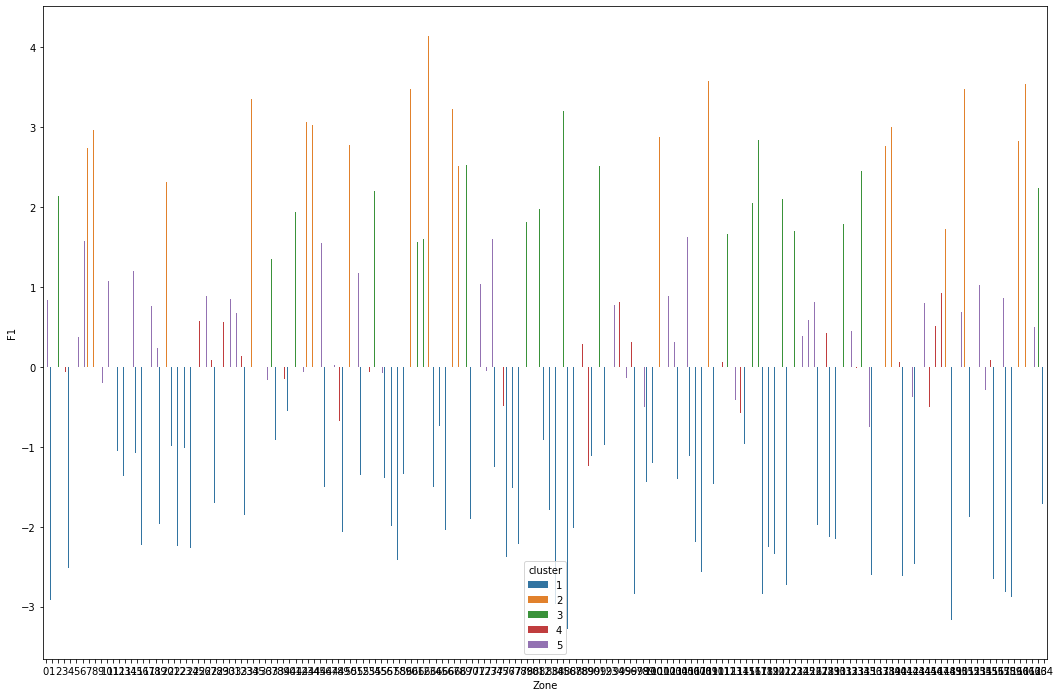

In [11]:
plt.figure(figsize=(18,12))

sns.barplot(x= dataParCluster.index, y='F1',data=dataParCluster, hue='cluster')

ax = plt.axes()
ax = ax.set(xlabel='Zone')

#### Représentation graphique de la variable synthétique F2 pour chaque zone

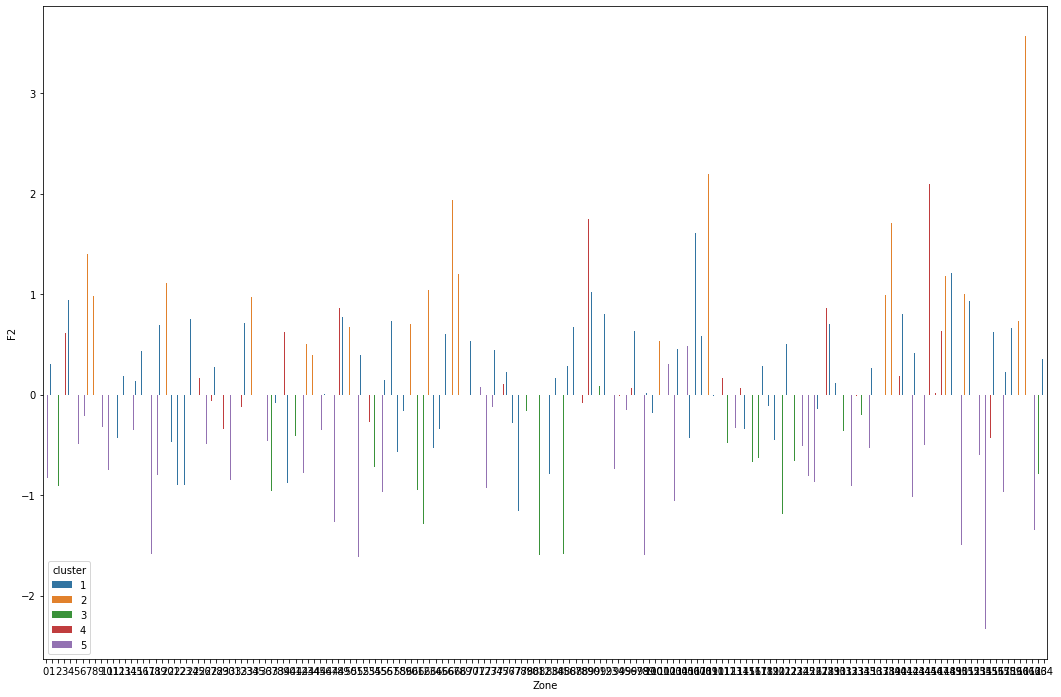

In [12]:
plt.figure(figsize=(18,12))

sns.barplot(x= dataParCluster.index, y='F2',data=dataParCluster, hue='cluster')

ax = plt.axes()
ax = ax.set(xlabel='Zone')

Pour le cluster 1, toutes les valeurs de F1 sont négatives et toutes les valeurs de F2 sont positives.

**Les individus du cluster 1 sont les pays à cibler pour notre étude de marché.** 

<a id="chapitre_8"></a>
## <span style="color: #030aa4">Liste des pays à cibler</span>

**Les pays du cluster 1 avec une variable synthétique F1 la plus basse sont nos pays cibles**. Cependant, puisque la baisse de cette variable synthétique permet de déduire des valeurs de variables recherchées sauf avec le PIB par habitant, **il convient d'abord d'identitifier les pays plus pauvres de ce cluster et d'en supprimer ceux sous le seuil de pauvreté**.

**Le seuil de pauvreté se situe à 1,9 dollars US par habitant par jour, soit 693,5 dollars US par an.**

Source : https://www.banquemondiale.org/fr/research/brief/poverty-and-shared-prosperity-2018-piecing-together-the-poverty-puzzle-frequently-asked-questions

In [13]:
PaysCibles = dataParCluster[dataParCluster.cluster==1]\
                        .drop(columns=["cluster","F2"])

dataPIB = data.loc[ : ,('pib_hab')]
dataPIB = dataPIB.reset_index()

PaysCibles = pd.merge(PaysCibles,dataPIB)
PaysCibles = PaysCibles.sort_values('F1')
PaysCibles = PaysCibles[PaysCibles['pib_hab']>693.5]

PaysCibles.head(10)

,Zone,F1,pib_hab
58,Ouganda,-3.166633,910.269755
62,Zambie,-2.880677,1660.761145
50,Rwanda,-2.726698,802.749353
56,République-Unie de Tanzanie,-2.614821,937.301492
54,Tadjikistan,-2.602206,1024.858954
44,Nigéria,-2.561670,2412.367125
1,Angola,-2.514335,3409.929285
21,Haïti,-2.420527,728.845002
28,Kenya,-2.377229,1156.425297
49,Zimbabwe,-2.340886,1263.321322


In [14]:
print("Il y a",len(PaysCibles), "pays à cibler.")

Il y a 52 pays à cibler.


<a id="chapitre_9"></a>
## <span style="color: #030aa4">Visualisation dans le premier plan factoriel obtenu par ACP</span>

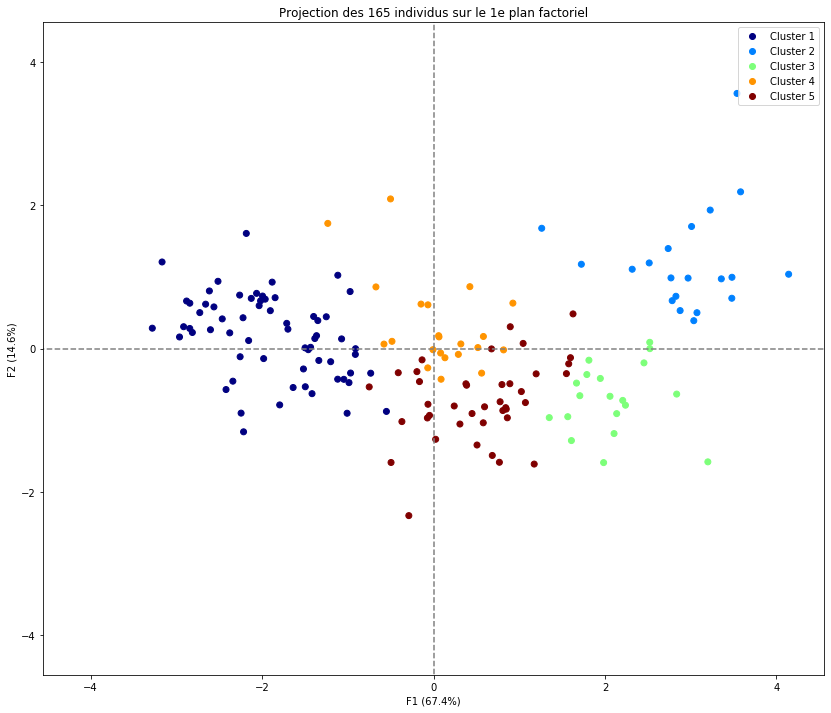

In [57]:
d1 = 0
d2 = 1

fig = plt.figure(figsize=(14,12))
cluster_values = list(dataClusters.cluster)
classes = list(np.unique(dataClusters.cluster))
classes = ['Cluster ' + str(x) for x in classes]
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], c=cluster_values, cmap = 'jet')

boundary = np.max(np.abs(X_projected[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])

# Affichage des axes
plt.plot([-100, 100], [0, 0], color = 'grey', ls='--')
plt.plot([0, 0], [-100, 100] , color = 'grey', ls='--')

# Nom des axes
plt.xlabel("F{} ({}%)".format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel("F{} ({}%)".format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.legend(handles = scatter.legend_elements()[0], labels = classes)
plt.show(block=False)

<a id="chapitre_10"></a>
## <span style="color: #030aa4">Test d'adéquation</span>

Il faut trouver une variable dont la loi est **normale**.
Les variables sont continues, nous allons utiliser le test de Shapiro-Wilk qui teste l'hypothèse nulle selon laquelle un échantillon est normalement distribué.

In [16]:
import scipy.stats

In [17]:
def test_adequation(x) :
       
    pvalue = scipy.stats.shapiro(x)[0]

    if pvalue > 0.05 :
        print("La p-value est égale à", round(pvalue,2),".")
        print("Elle est est supérieure au niveau de test 5%.")
        print("On ne peut pas rejeter l'hypothèse nulle.")
    else:
        print("La p-value est égale à", round(pvalue,2),".")
        print("Elle est est inférieure au niveau de test 5%.")
        print("On peut rejeter l'hypothèse nulle.")
        print("L'échantillon n'est pas normalement distribué.")
            
x1 = data['diff_pop']
x2 = data['disp_alim']
x3 = data['disp_prot']
x4 = data['pib_hab']
x5 = data['prop_prot']

test_adequation(x1)
print("-"*50)
print(" ")
test_adequation(x2)
print("-"*50)
print(" ")
test_adequation(x3)
print("-"*50)
print(" ")
test_adequation(x4)
print("-"*50)
print(" ")
test_adequation(x5)

La p-value est égale à 0.99 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
--------------------------------------------------
 
La p-value est égale à 0.98 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
--------------------------------------------------
 
La p-value est égale à 0.98 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
--------------------------------------------------
 
La p-value est égale à 0.7 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
--------------------------------------------------
 
La p-value est égale à 0.96 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.


On ne peut rejeter l'hypothèse nulle pour aucune variable. Ce qui signifie qu'elle peuvent toutes suivre une loi normale mais à ce stade du test, il n'est pas possible de s'en assurer.

#### Affichage de la distribution de la différence de population entre 2016 et 2017 et comparaison avec une loi normale :

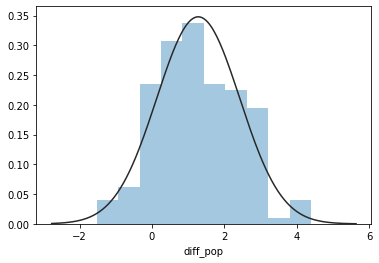

In [18]:
from scipy.stats import norm
sns.distplot(data['diff_pop'], fit=norm, kde=False)

**La distribution de la différence de population suit la loi normale.**

<a id="chapitre_11"></a>
## <span style="color: #030aa4">Test de comparaison</span>

Le test de comparaison consiste à comparer la variance et la moyenne de deux variables.
Préalablement, il faut vérifier que les variables comparées sont **gaussiennes**.

#### Test d'adéquation des variables F1 des clusters 2 et 3  pour savoir si les variables sont gaussiennes :

In [19]:
dataParCluster2 = dataParCluster[dataParCluster.cluster==2]
dataParCluster3 = dataParCluster[dataParCluster.cluster==3]

print("Test d'adéquation de la variable F1 du cluster 2 :")
print(" ")
test_adequation(dataParCluster2.F1)
print(" ")
print("-"*50)
print(" ")
print("Test d'adéquation de la variable F1 du cluster 3 :")
print(" ")
test_adequation(dataParCluster3.F1)

Test d'adéquation de la variable F1 du cluster 2 :
 
La p-value est égale à 0.94 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.
 
--------------------------------------------------
 
Test d'adéquation de la variable F1 du cluster 3 :
 
La p-value est égale à 0.96 .
Elle est est supérieure au niveau de test 5%.
On ne peut pas rejeter l'hypothèse nulle.


#### Histogrammes des variables F1 des clusters 2 et 3 :

Text(0.5, 1.0, 'Histogramme cluster 2 (F1) et densité normale')

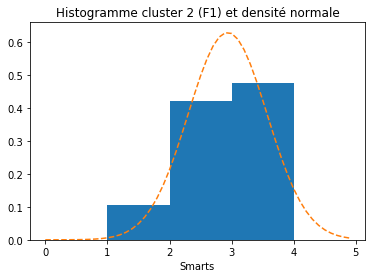

In [20]:
xbar = np.mean(dataParCluster2.F1)
sprime = np.std(dataParCluster2.F1)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(dataParCluster2.F1,normed = True, bins = range(0,5))
bins = np.arange(0,5,0.1)
y = scipy.stats.norm.pdf(bins, xbar,sprime)
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_title("Histogramme cluster 2 (F1) et densité normale")

Text(0.5, 1.0, 'Histogramme cluster 3 (F1) et densité normale')

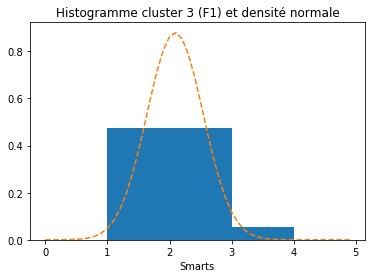

In [21]:
xbar = np.mean(dataParCluster3.F1)
sprime = np.std(dataParCluster3.F1)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(dataParCluster3.F1,normed = True, bins = range(0,5))
bins = np.arange(0,5,0.1)
y = scipy.stats.norm.pdf(bins, xbar,sprime)
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_title("Histogramme cluster 3 (F1) et densité normale")

Les deux variables sont gaussiennes, nous pouvons appliquer un test de comparaison.

#### Test de comparaison des clusters 2 et 3 :

In [22]:
dataParCluster2 = dataParCluster[dataParCluster.cluster==2]
dataParCluster3 = dataParCluster[dataParCluster.cluster==3]

print("Test de comparaison de la variable F1 des clusters 2 et 3 :")
print(" ")

# Égalité des variances :

pvalueVar = scipy.stats.bartlett(dataParCluster2.F1,dataParCluster3.F1)[1]

if pvalueVar > 0.05 :
    print("Pour les variances, la p-value est égale à", round(pvalueVar,2),".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne rejette pas l'égalité des variances.")
else:
    print("Pour les variances, la p-value est égale à", round(pvalueVar,2),".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse d'égalité des variances.")

print(" ")
print("-"*60)
print(" ")
    
# Égalité des moyennes :

pvalueMean = scipy.stats.ttest_ind(dataParCluster2.F1,dataParCluster3.F1, equal_var=True)[1]

if pvalueMean > 0.05 :
    print("Pour les moyennes, la p-value est égale à", pvalueMean,".")
    print("Elle est est supérieure au niveau de test 5%.")
    print("On ne rejette pas l'égalité des moyennes.")
else:
    print("Pour les moyennes, la p-value est égale à", pvalueMean,".")
    print("Elle est est inférieure au niveau de test 5%.")
    print("On peut rejeter l'hypothèse d'égalité des moyennes.")

Test de comparaison de la variable F1 des clusters 2 et 3 :
 
Pour les variances, la p-value est égale à 0.16 .
Elle est est supérieure au niveau de test 5%.
On ne rejette pas l'égalité des variances.
 
------------------------------------------------------------
 
Pour les moyennes, la p-value est égale à 4.287573208677548e-05 .
Elle est est inférieure au niveau de test 5%.
On peut rejeter l'hypothèse d'égalité des moyennes.


L'hypothèse d'égalité des moyennes est rejetée. **Les clusters 2 et 3 ne suivent pas la même distribution.**